# Food Vison Tensorflow Project
-------------------------------

In this notebook, I will execute a small milestone project after learning **Computer Vision** with TensorFlow.
I will:

- Select the most suitable pretrained model to apply to the dataset from the original "Food 101" research.
- Work on the data by loading, preprocessing, normalizing, visualizing, and preparing it for training.
- Set up some callbacks.
- Add a data augmentation layer and construct the model.
- Fine-tune the model using the data.
- Track and compare the experiments using TensorBoard.

### This time I've got the goal of beating DeepFood, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

Also, I will use **Mixed Precision** training on my *NVIDIA GEFORCE RTX 4070* to speed up the training process.  
It is compatible since it has __Compute Capability__ of *8.9*.

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4070 Laptop GPU (UUID: GPU-d931b724-0b2d-5481-ae77-5e084de922e0)


### Note: 
I have a prepared script with some 'pre-made' functions (`helper_functions.py`), I wrote myself, when going through the earlier stages of the course I am following on Tensorflow.   
I provided it in this repo.

In [17]:
# Imports:
import tensorflow as tf
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
import warnings # to clean up some outputs
import numpy as np

In [3]:
# I use the version of tensorflow == '2.10' since it works nicely with GPU powered training
tf.__version__

'2.10.0'

#### I will use tensorflow Datasets to Download the data needed

In [4]:
'food101' in tfds.list_builders()

True

In [4]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True, 
                                             with_info=True)

In [6]:
# Features of Food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# Let's take one sample of train data
train_one_sample = train_data.take(1)

In [9]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class from Food101 (tensor from): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class from Food101 (tensor from): 43
    Class name (str form): fried_calamari
    


In [11]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[71, 60, 56],
        [70, 59, 55],
        [70, 59, 55],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[62, 51, 47],
        [64, 53, 49],
        [66, 55, 51],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[61, 50, 46],
        [65, 54, 50],
        [68, 57, 53],
        ...,
        [66, 61, 68],
        [65, 60, 67],
        [63, 58, 65]],

       ...,

       [[63, 64, 66],
        [64, 65, 67],
        [67, 67, 69],
        ...,
        [45, 42, 49],
        [45, 42, 49],
        [45, 42, 49]],

       [[64, 64, 66],
        [64, 64, 66],
        [65, 65, 67],
        ...,
        [44, 41, 48],
        [44, 41, 48],
        [44, 41, 48]],

       [[62, 62, 64],
        [62, 62, 64],
        [62, 62, 64],
        ...,
        [43, 40, 47],
        [42, 39, 46],
        [42, 39, 46]]], dtype=uint8)>

In [12]:
# What are the min and max values of our image tensor
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an Image from TensorFlow DataSets

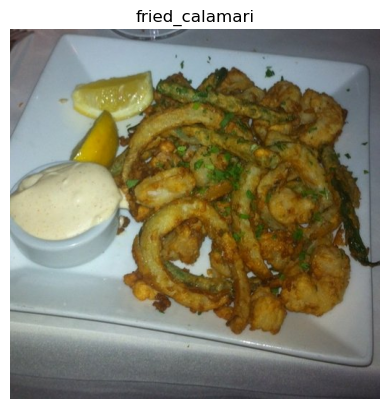

In [13]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our Data
- Our data is not scaled (the pixel values are between 0 & 255)
- Data is of different size tensors
- We have the `uint8` datatype, not `float32` or `float16`
- Not batched

However, since I am going to use EfficientNetV2Bx pretrained model from tf.keras.applications 
I don't need to rescale the data (these architectures ahev rescaling layers built-in).

In [5]:
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from `unit8` -> `float32` and reshapes
    image to [img_shape, img_shape. colour_channels]
    """

    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label # returns (float32_image, label) tuple

In [15]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[71 60 56]
  [70 59 55]
  [70 59 55]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]

 [[62 51 47]
  [64 53 49]
  [66 55 51]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 65.81122   54.811222  50.811222]
  [ 73.331635  62.331635  58.331635]
  [104.015305  89.80102   86.80102 ]
  ...
  [ 61.85712   59.071384  65.64286 ]
  [ 65.        60.        67.      ]
  [ 64.64282   59.642822  66.64282 ]]

 [[ 67.28571   56.285717  52.285717]
  [ 66.47449   55.47449   51.47449 ]
  [ 67.73979   53.525505  50.525505]
  ...
  [ 64.14284   61.3571    67.92857 ]
  [ 65.93368   60.933674  67.93368 ]
  [ 64.285645  59.285645  66.285645]]]..., 
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


I tried to stick to the best-practices here

In [6]:
# Preprocess all images in train_data
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) # parallelize it for better performance
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Now for the test_data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [7]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modeling callbacks

* TensorBoard callback to log training results (so we can visualize them later)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [66]:
# create_tensorboard_callback() func form helper_functions.py
def create_checkpoint(exp_name):
    checkpoint_path = f'FoodVis_checkpoints/{exp_name}/{exp_name}_cp.ckpt'
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1  # Optional: shows saving logs
    )
    return model_checkpoint

## Set-up Mixed precision

In [19]:
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9


## Create a DataAugmentation Layer

In [20]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1),
], name = 'data_augment')

## Add EarlyStopping and LR scheduler, we will use them when finetuning

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-7)

## Build feature extraction model

In [25]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(), # leave the default lr (0.001), usually it's good for starters
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augment (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0   

### Checking layer dtype policies

In [27]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
data_augment True float32 <Policy "mixed_float16">
efficientnetv2-b0 False float32 <Policy "mixed_float16">
global_average_pooling2d_3 True float32 <Policy "mixed_float16">
dense_3 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [28]:
for layer in model.layers[2].layers[:20]: # check the layers of the base model
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_4 False float32 <Policy "float32">
rescaling_3 False float32 <Policy "mixed_float16">
normalization_3 False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float16">
block2a_project_bn False float32 <Policy "mixed_float16">
block2b_expand_conv False float32 <Policy "mixed_float16">
block2b_expand_bn False float32 <Policy "mixed_float16">
block2b_expand_activation False float32 <Policy "mixed_float16">
block2b_project_conv False float32 <Po

## Fit the feature extraction model

In [31]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')         # Hide tf warnings
feature_extraction_history = model.fit(train_data,
                                       epochs=3,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps=int(0.15 * len(test_data)),
                                       callbacks=[create_tensorboard_callback(dir_name="food_vis_training_logs",
                                                                              experiment_name='effnetV2B0_feature_extract'),
                                                                              create_checkpoint(exp_name='feat_extr_effV2B0')])

Saving TensorBoard log files to: food_vis_training_logs/effnetV2B0_feature_extract/20250528-183220
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 2.0848 - accuracy: 0.4907
Epoch 1: val_accuracy improved from -inf to 0.63957, saving model to FoodVis_checkpoints\feat_extr_effV2B0_cp.ckpt
2368/2368 [==============================] - 1008s 425ms/step - loss: 2.0848 - accuracy: 0.4907 - val_loss: 1.3274 - val_accuracy: 0.6396
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7224 - accuracy: 0.5644
Epoch 2: val_accuracy improved from 0.63957 to 0.67135, saving model to FoodVis_checkpoints\feat_extr_effV2B0_cp.ckpt
2368/2368 [==============================] - 1026s 433ms/step - loss: 1.7224 - accuracy: 0.5644 - val_loss: 1.2075 - val_accuracy: 0.6713
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.6129 - accuracy: 0.5888
Epoch 3: val_accuracy improved from 0.67135 to 0.68008, saving model to FoodVis_checkpoints\feat_extr

In [33]:
# Cleaning-up our kernel (it crashed a few times when I tried to evaluate the model)
import tensorflow.keras.backend as K
K.clear_session()
import gc
gc.collect()

727

In [34]:
feat_extr_results = model.evaluate(test_data)

790/790 [==============================] - 83s 104ms/step - loss: 1.1714 - accuracy: 0.6799


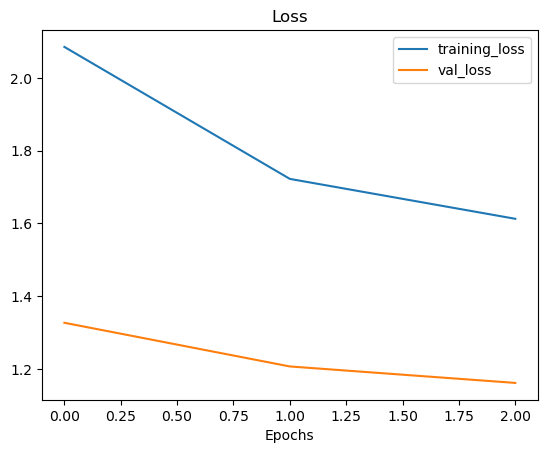

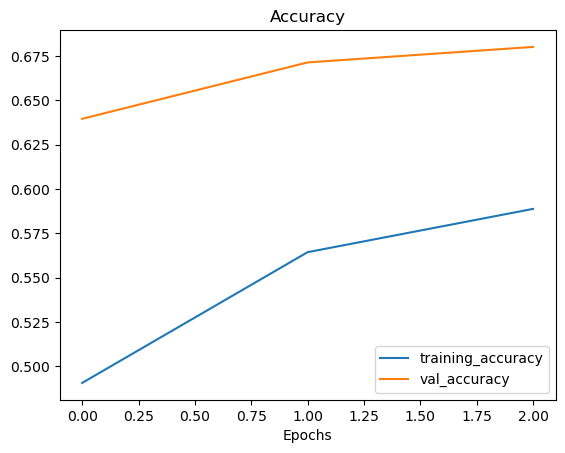

In [46]:
plot_loss_curves(feature_extraction_history)

## Fine-Tuning The model

In [39]:
# Setting the base model to be trainable
base_model.trainable = True

In [40]:
# Freezeing back all layers, exept last 15
for layer in base_model.layers[:-15]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    print(layer.name, layer.trainable)

block6g_drop False
block6g_add False
block6h_expand_conv False
block6h_expand_bn False
block6h_expand_activation False
block6h_dwconv2 True
block6h_bn True
block6h_activation True
block6h_se_squeeze True
block6h_se_reshape True
block6h_se_reduce True
block6h_se_expand True
block6h_se_excite True
block6h_project_conv True
block6h_project_bn True
block6h_drop True
block6h_add True
top_conv True
top_bn True
top_activation True


In [43]:
for layer in model.layers:
    print(layer, layer.trainable, layer.dtype_policy)

<keras.engine.input_layer.InputLayer object at 0x00000162F1D63790> True <Policy "float32">
<keras.engine.sequential.Sequential object at 0x0000016126DB8790> True <Policy "mixed_float16">
<keras.engine.functional.Functional object at 0x00000162F1D6DA80> True <Policy "mixed_float16">
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x00000162F08B6770> True <Policy "mixed_float16">
<keras.layers.core.dense.Dense object at 0x00000162F175B430> True <Policy "mixed_float16">
<keras.layers.core.activation.Activation object at 0x00000162F3013E80> True <Policy "float32">


In [42]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augment (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0   

In [44]:
# Recompile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # lower the lr
              metrics = ['accuracy'])

In [47]:
first_fine_tuning_history = model.fit(train_data,
                                      epochs=10, # fine-tune for a maximum of 10 epochs
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15*len(test_data)), # again, validation during training on 15% of test data
                                      initial_epoch=3,
                                      callbacks=[create_tensorboard_callback(dir_name='food_vis_training_logs',
                                                                             experiment_name='effnetV2B0_first_fine_tune'),
                                                create_checkpoint(exp_name='fine_tune_1'),
                                                reduce_lr, early_stop])

Saving TensorBoard log files to: food_vis_training_logs/effnetV2B0_first_fine_tune/20250528-220414
Epoch 4/10
2368/2368 [==============================] - ETA: 0s - loss: 1.3933 - accuracy: 0.6380
Epoch 4: val_accuracy improved from -inf to 0.72007, saving model to FoodVis_checkpoints\fine_tune_1_cp.ckpt
2368/2368 [==============================] - 992s 414ms/step - loss: 1.3933 - accuracy: 0.6380 - val_loss: 1.0310 - val_accuracy: 0.7201 - lr: 1.0000e-04
Epoch 5/10
2368/2368 [==============================] - ETA: 0s - loss: 1.2875 - accuracy: 0.6637
Epoch 5: val_accuracy improved from 0.72007 to 0.72590, saving model to FoodVis_checkpoints\fine_tune_1_cp.ckpt
2368/2368 [==============================] - 980s 414ms/step - loss: 1.2875 - accuracy: 0.6637 - val_loss: 0.9927 - val_accuracy: 0.7259 - lr: 1.0000e-04
Epoch 6/10
2368/2368 [==============================] - ETA: 0s - loss: 1.2256 - accuracy: 0.6782
Epoch 6: val_accuracy improved from 0.72590 to 0.72828, saving model to FoodVi

### Again, the **goal results** of this projects is to beat `77.4%+ top-1 accuracy`, so let's move further.

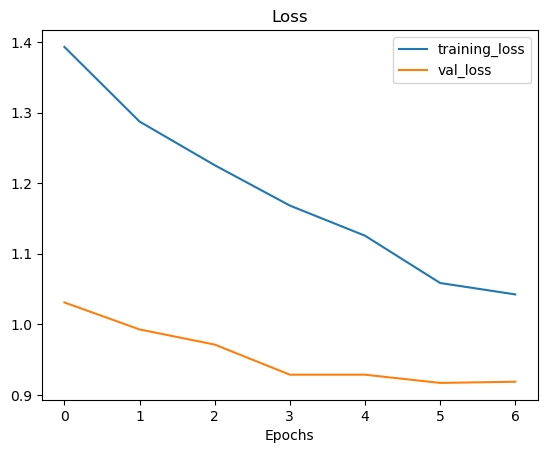

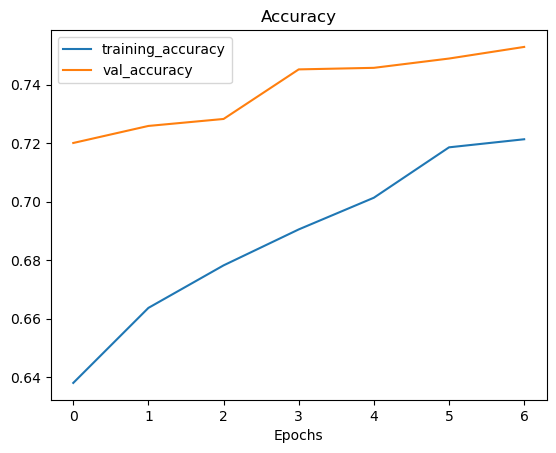

In [48]:
plot_loss_curves(first_fine_tuning_history)

In [49]:
# evaluate on the whole dataset 
first_fine_tuning_results = model.evaluate(test_data)

790/790 [==============================] - 80s 101ms/step - loss: 0.9313 - accuracy: 0.7430


It seems to me like we have some more potencial for our model to be perfected.   
- How about we try to unfreeze a few more layers.

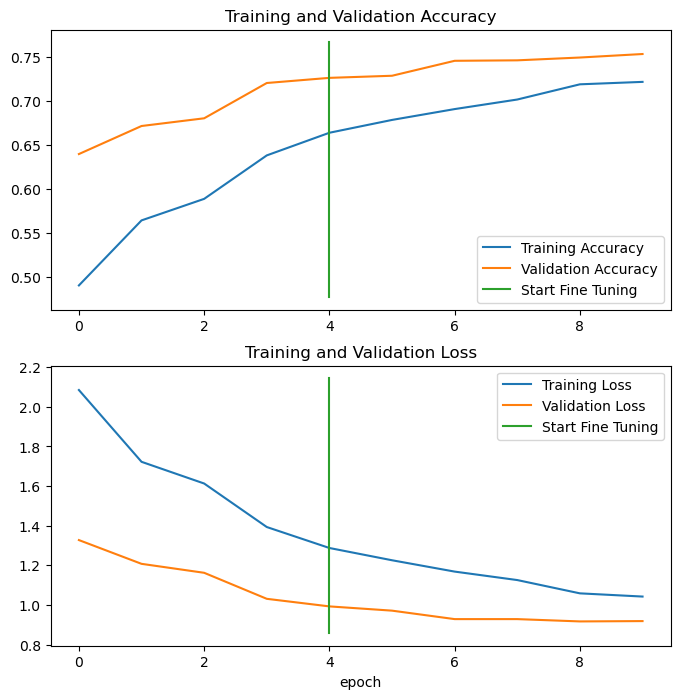

In [50]:
compare_historys(original_history=feature_extraction_history,
                 new_history=first_fine_tuning_history)

In [52]:
# Let's see how many layers our base model has at all
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

270 layers

In [62]:
for layer_number, layer in enumerate(model.layers[2].layers):
    if 'block6' in layer.name:
        print(layer_number, layer.name, layer.trainable, layer.dtype_policy)

149 block6a_expand_conv True <Policy "mixed_float16">
150 block6a_expand_bn True <Policy "mixed_float16">
151 block6a_expand_activation True <Policy "mixed_float16">
152 block6a_dwconv2 True <Policy "mixed_float16">
153 block6a_bn True <Policy "mixed_float16">
154 block6a_activation True <Policy "mixed_float16">
155 block6a_se_squeeze True <Policy "mixed_float16">
156 block6a_se_reshape True <Policy "mixed_float16">
157 block6a_se_reduce True <Policy "mixed_float16">
158 block6a_se_expand True <Policy "mixed_float16">
159 block6a_se_excite True <Policy "mixed_float16">
160 block6a_project_conv True <Policy "mixed_float16">
161 block6a_project_bn True <Policy "mixed_float16">
162 block6b_expand_conv True <Policy "mixed_float16">
163 block6b_expand_bn True <Policy "mixed_float16">
164 block6b_expand_activation True <Policy "mixed_float16">
165 block6b_dwconv2 True <Policy "mixed_float16">
166 block6b_bn True <Policy "mixed_float16">
167 block6b_activation True <Policy "mixed_float16">
16

### **EfficientNetV2B0** has more than **100 layers** in it's last block.
### That is a lot, however, since we have A LOT of training samples, data augmentation, early stopping..., I think, it is a good idea to unfreeze this whole block for the next round of the fine tuning.

In [56]:
base_model.trainable = True

# Freeze all layers except the last 149
for layer in base_model.layers[:-149]:
    layer.trainable = False

# Track ranges
frozen_indices = []
trainable_indices = []

for i, layer in enumerate(base_model.layers):
    if layer.trainable:
        trainable_indices.append(i)
    else:
        frozen_indices.append(i)

print(f"\nFrozen layers: {frozen_indices[0]} to {frozen_indices[-1]} ({len(frozen_indices)} layers)")
print(f"Trainable layers: {trainable_indices[0]} to {trainable_indices[-1]} ({len(trainable_indices)} layers)")


Frozen layers: 0 to 120 (121 layers)
Trainable layers: 121 to 269 (149 layers)


In [61]:
# Recompile the model again
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002), # lowering lr even more
              metrics = ['accuracy'])

In [63]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augment (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0   

In [64]:
import tensorflow.keras.backend as K
K.clear_session()
import gc
gc.collect()

17036

In [65]:
# adjust the early stopping and reduceLR callbacks accordingly to the new experiment
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-7)

In [68]:
second_fine_tuning_history = model.fit(train_data,
                                      epochs=25, # train for maximum 15 epochs
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15*len(test_data)),
                                      initial_epoch=10,
                                      callbacks=[create_tensorboard_callback(dir_name='food_vis_training_logs',
                                                                             experiment_name='effnetV2B0_second_fine_tune_block'),
                                                create_checkpoint(exp_name='fine_tune_2_block'),
                                                reduce_lr, early_stop])

Saving TensorBoard log files to: food_vis_training_logs/effnetV2B0_second_fine_tune_block/20250529-155502
Epoch 11/25
2368/2368 [==============================] - ETA: 0s - loss: 0.9870 - accuracy: 0.7339
Epoch 11: val_accuracy improved from -inf to 0.76695, saving model to FoodVis_checkpoints/fine_tune_2_block\fine_tune_2_block_cp.ckpt
2368/2368 [==============================] - 1163s 491ms/step - loss: 0.9870 - accuracy: 0.7339 - val_loss: 0.8411 - val_accuracy: 0.7669 - lr: 2.0000e-05
Epoch 12/25
2368/2368 [==============================] - ETA: 0s - loss: 0.8950 - accuracy: 0.7581
Epoch 12: val_accuracy improved from 0.76695 to 0.77701, saving model to FoodVis_checkpoints/fine_tune_2_block\fine_tune_2_block_cp.ckpt
2368/2368 [==============================] - 999s 422ms/step - loss: 0.8950 - accuracy: 0.7581 - val_loss: 0.8103 - val_accuracy: 0.7770 - lr: 2.0000e-05
Epoch 13/25
2368/2368 [==============================] - ETA: 0s - loss: 0.8385 - accuracy: 0.7709
Epoch 13: val_acc

In [69]:
K.clear_session()
import gc
gc.collect()

91

In [70]:
results_twice_finetuned = model.evaluate(test_data)

790/790 [==============================] - 75s 94ms/step - loss: 0.8020 - accuracy: 0.7817


### And now, with that second fine-tuning, the goal of top-1 accuracy was achieved. 
### Although the model did not significantly outperform 77.4% accuracy, it starts to overfit, so we shall stop here.
## After the last evaluation, we got **78.17% accuracy**.

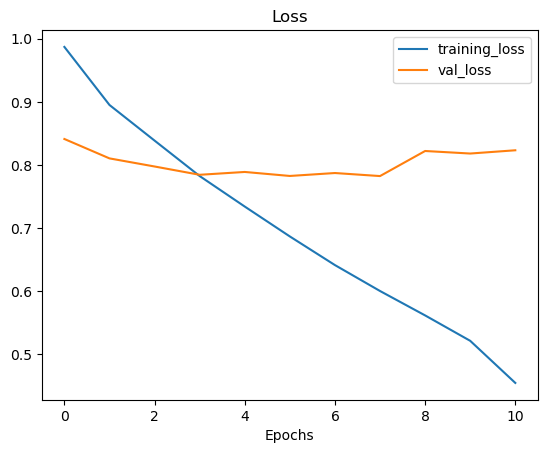

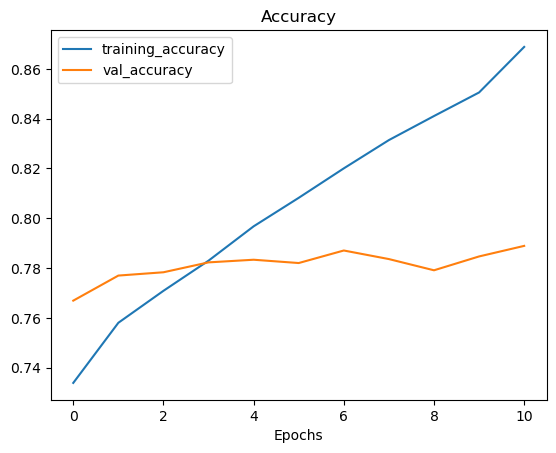

In [71]:
plot_loss_curves(second_fine_tuning_history)

### Note: 
### Due to the limited power of my computer, trainings were a lot more time-consuming than I initially expected (I have a laptop version of 4070 and it has only 8GB of memory). 
### If there were no problem with that, I would:
- For the second fine-tuning, I would unfreeze the whole base model. It would allow me to extract even more accuracy. Since the dataset is huge, it would not result in overfitting.
- Try to use a more 'heavy-weight' version of the EfficientNetV2 (B2, B3, B4). These architectures are still not too big, however, a noticeable difference in run time would occur.    
With these suggested approaches, I believe, it would be possible to achieve a lot better results.

## Save the model:

In [72]:
save_path = 'models/EfficientNetV2B0_finetuned'
model.save(filepath=save_path)

## View training results on *TensorBoard*

In [ ]:
#tensorboard --logdir ./food_vis_training_logs/

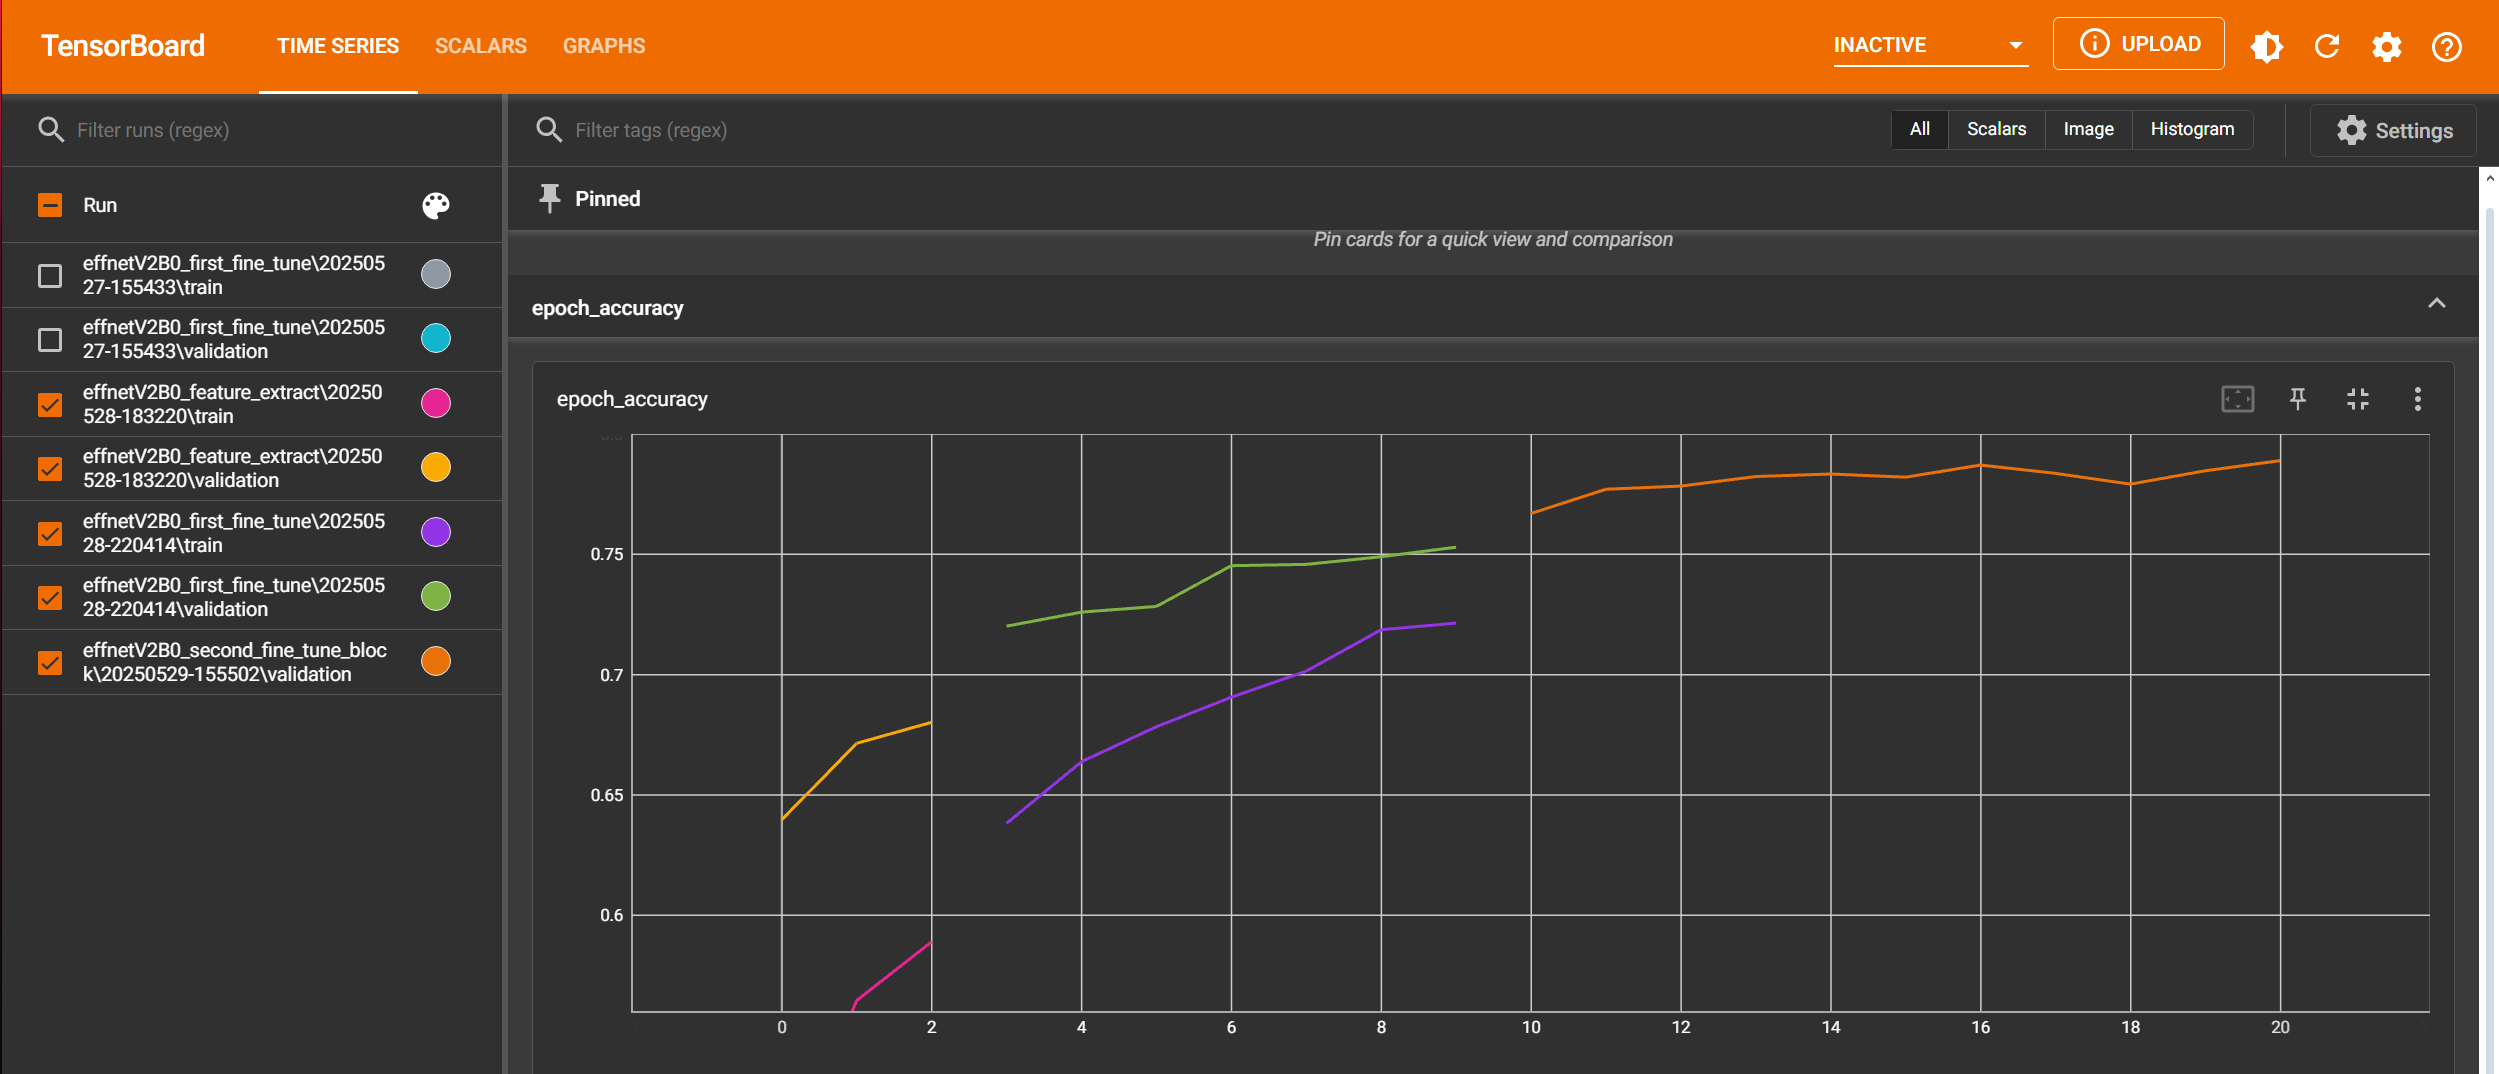

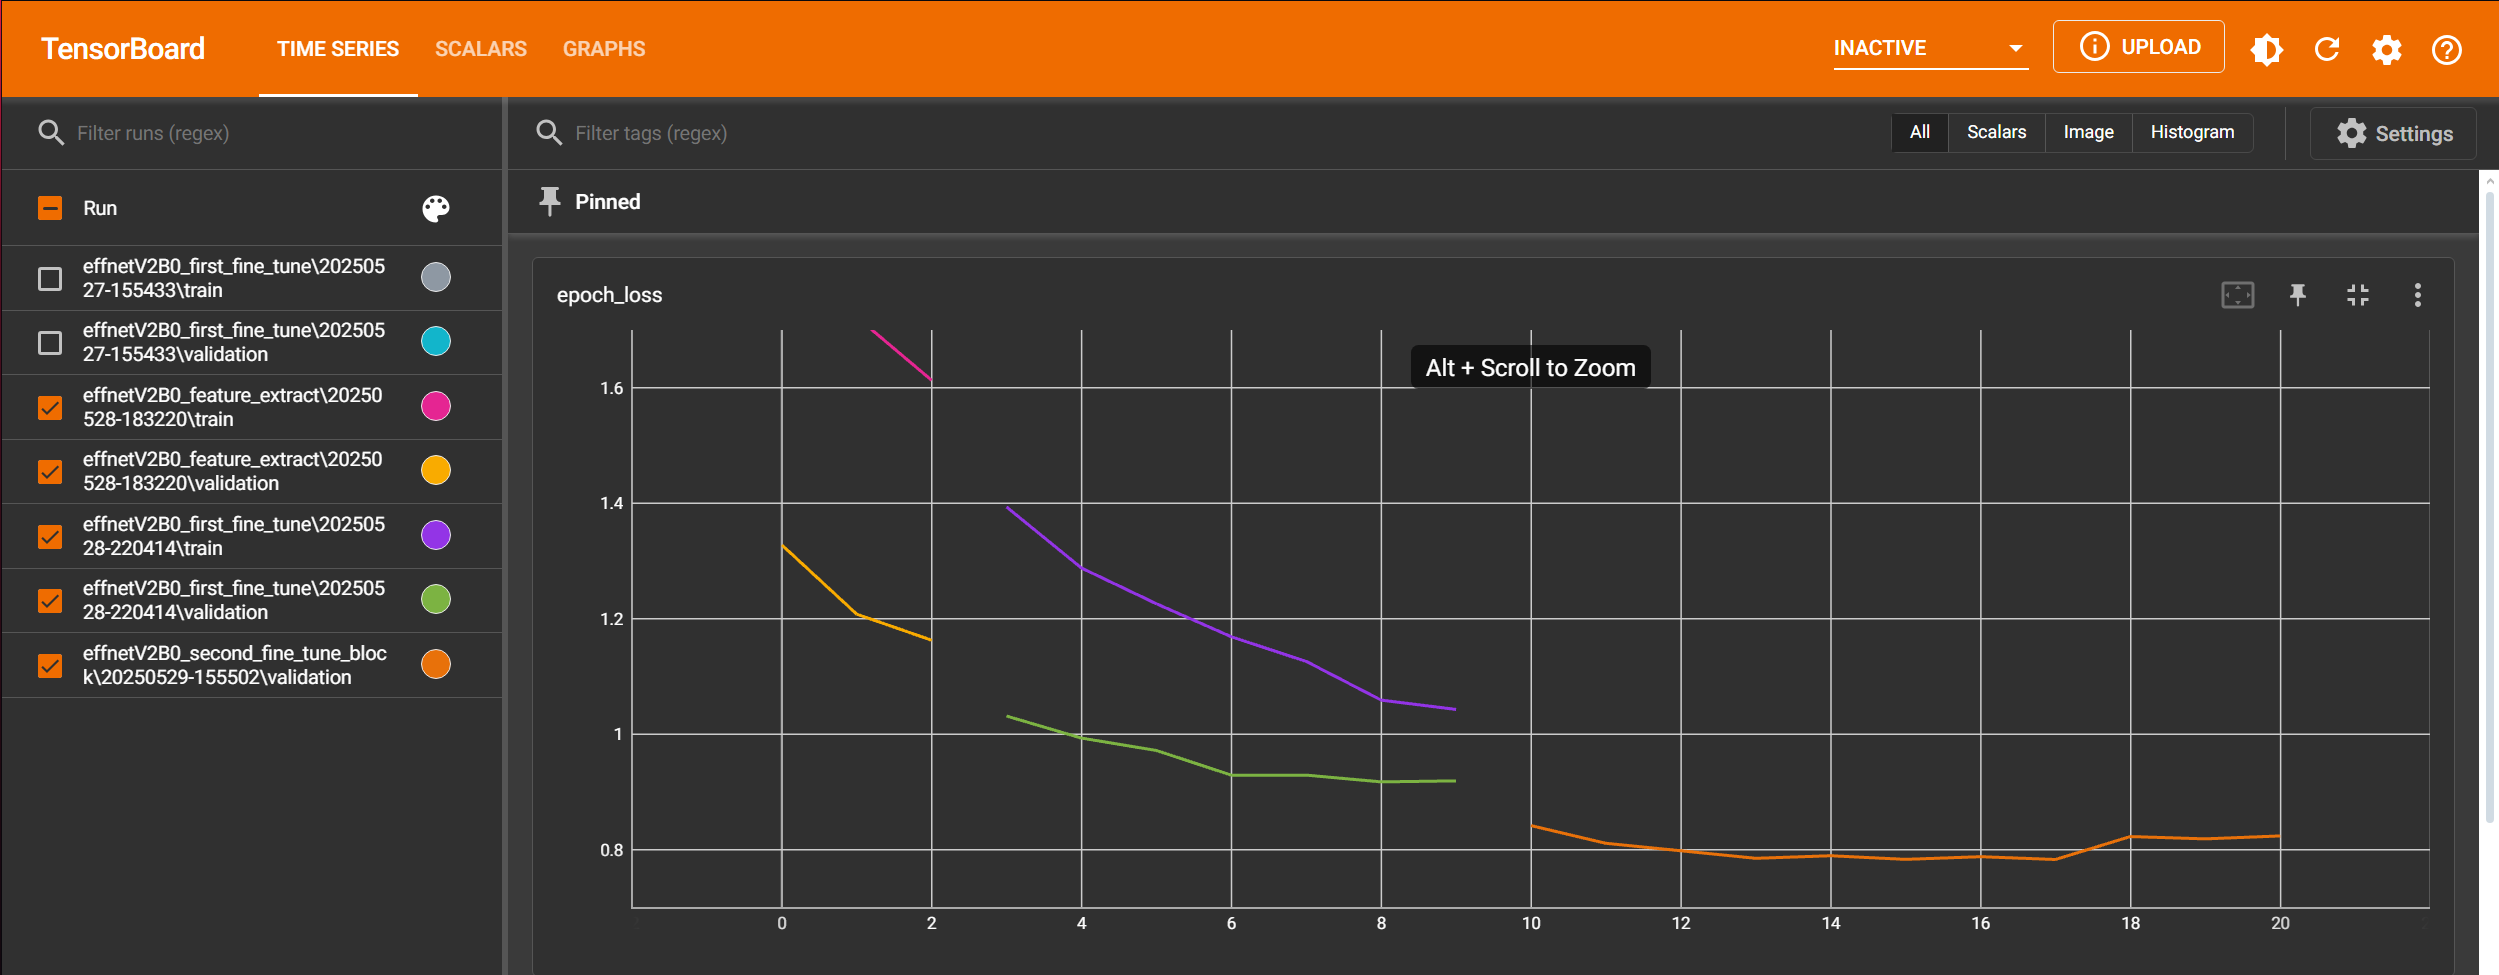